#Устанавливаем библиотеки для работы:

*   torch torchvision PyTorch для нейросетей<br>
*   transformers для моделей из HuggingFace<br>
*   datasets для работы с датасетами<br>
*   kagglehub чтобы качать датасеты с Kaggle<br>
*   pillow изображения<br>
*   accelerate для оптимизации обучения<br>



In [3]:
!pip install nbconvert -q

In [4]:
!jupyter nbconvert --to notebook --inplace --ClearMetadataPreprocessor.enabled=True "project_practice_uramaev.ipynb"

[NbConvertApp] WARNING | pattern 'project_practice_uramaev.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]


In [1]:
!pip install -q torch torchvision transformers datasets kagglehub pandas pillow scikit-learn matplotlib seaborn
!pip install -q accelerate

In [2]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from transformers import ViTForImageClassification, ViTImageProcessor
import matplotlib.pyplot as plt
import kagglehub
import warnings
warnings.filterwarnings('ignore')

# Загружаем датасет

In [3]:
print("Скачивание датасета HAM10000...")
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

Скачивание датасета HAM10000...
Using Colab cache for faster access to the 'skin-cancer-mnist-ham10000' dataset.


Наш датасет содержит как изображения, так и метаданные к ним. Пропишем пути и загрузим описания

In [4]:
metadata_path = os.path.join(path, "HAM10000_metadata.csv")
image_dir = path

df = pd.read_csv(metadata_path)
print(f"Всего изображений: {len(df)}")
print("\nРаспределение классов:")
print(df['dx'].value_counts())

Всего изображений: 10015

Распределение классов:
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


Датасет имеет множество классов. Будем делать бинарную классификацию, опасна ли условная родинка или нет. В будущем проблему переобучения на классах где мало данных можно будет решить обогащением датасета. Плюс визуально признаки довольно сильно пересекаются.<br>
Так что поделим диагнозы из датасета на две группы:<br>
Первая группа доброкачественные, к ним будут относится классы:<br>
nv - родинка<br>
bkl - доброкачественное кератозное изменение<br>
df - дерматофиброма<br>
vasc - сосудистые поражения<br>
Вторая группа это опасные образования, типо злокачественных и предраковых<br>
mel - меланома<br>
bcc - базально-клеточный рак<br>
akiec - актинический кератоз<br>

In [5]:
def map_to_binary(diagnosis):
    notdanger = ['nv', 'bkl', 'df', 'vasc']
    danger = ['mel', 'bcc', 'akiec']

    if diagnosis in notdanger:
        return 0
    elif diagnosis in danger:
        return 1
    else:
        return -1  # если диагноз другой

Создаем новый столбец label и в нем убираем строки, где map_to_binary вернул -1.<br>
То есть оставляем только два класса: 0 и 1.

В процессе разработки было выявлено, что модель слишком сильно запоминает доброкачественные примеры. Так что ограничим кол-во изображений

In [6]:
df['label'] = df['dx'].apply(map_to_binary)
df = df[df['label'] != -1]

# ограничим количество доброкачественных
notdanger_df = df[df['label'] == 0].sample(n=2000, random_state=42)
danger_df = df[df['label'] == 1]
df_balanced = pd.concat([notdanger_df, danger_df])

print(f"\nПосле балансировки:")
print(f"Доброкачественные (0): {len(df_balanced[df_balanced['label'] == 0])}")
print(f"Злокачественные/опасные (1): {len(df_balanced[df_balanced['label'] == 1])}")


После балансировки:
Доброкачественные (0): 2000
Злокачественные/опасные (1): 1954


#Создание Dataset класса
Класс SkinLesionDataset отвечает за загрузку изображений по image_id из датасета. Если изображение отсутствует, используется заглушка: чёрная картинка, чтобы обучение не падало. Также в классе предусмотрено применение преобразований типо resize и нормализации, а на выход подаются готовые тензоры изображения и метки. Вся сложность структуры датасета обходится тк данные приводтся к единому формату, которая примет нейросеть.


In [7]:
class SkinLesionDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_id = row['image_id']

        possible_paths = [
            os.path.join(self.image_dir, f"{image_id}.jpg"),
            os.path.join(self.image_dir, "HAM10000_images_part_1", f"{image_id}.jpg"),
            os.path.join(self.image_dir, "HAM10000_images_part_2", f"{image_id}.jpg"),
        ]

        image_path = None
        for path in possible_paths:
            if os.path.exists(path):
                image_path = path
                break

        if image_path is None:
            image = Image.new('RGB', (224, 224), color='black')
        else:
            image = Image.open(image_path).convert('RGB')

        label = row['label']

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

#Делим данные на тренировочную, валидационную и тестовую выборки
Три части: обучающая, валидационная и тестовая, а стратификация, чтобы сохранить одинаковое соотношение классов в каждом наборе данных. Сначала мы отделяем 30 процентов данных во временный набор, затем делим его пополам: одна половина становится валидацией, другая тестом. Так мы сможем корректно оценивать модель, то есть обучение идёт только на train, подбор гиперпараметров и отслеживание переобучения на валидации, а финальная независимая проверка качества на тесте.


In [8]:
train_df, temp_df = train_test_split(df_balanced, test_size=0.3, stratify=df_balanced['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print(f"\nРазделение данных:")
print(f"Обучающая выборка: {len(train_df)}")
print(f"Валидационная выборка: {len(val_df)}")
print(f"Тестовая выборка: {len(test_df)}")



Разделение данных:
Обучающая выборка: 2767
Валидационная выборка: 593
Тестовая выборка: 594


#Трансформации
Реальные фотографии родинок сильно отличаются по освещению и ракурсу, так что в обучающей выборке используются случайные повороты, отражения и изменение яркости и контрастности чтобы искусственно увеличить разнообразие данных и снизить переобучение. Затем изображения приводятся к фиксированному размеру 224×224, преобразуются в тензоры и нормализуются под параметры предобученных моделей.

In [9]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = SkinLesionDataset(train_df, image_dir, train_transform)
val_dataset = SkinLesionDataset(val_df, image_dir, val_transform)
test_dataset = SkinLesionDataset(test_df, image_dir, val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Загрузка предобученной модели

Подгружаем готовую модель Vision Transformer, которую уже обучили на огромной базе картинок ImageNet-21k. Она хорошо умеет вытаскивать общие признаки с изображений, и мы используем её как основу. Дальше мы переобучаем её под нашу задачу.
Сначала загружается ViTImageProcessor процессор который знает, как правильно подготовить картинку для ViT. Потом грузится сама модель, и мы говорим ей, что у нас всего два класса родинка либо опасная, либо нет. Параметр ignore_mismatched_sizes=True нужен для того, чтобы аккуратно заменить последний слой модели на наш собственный слой под два класса, и при этом не сломать остальные слои.

In [10]:
model_name = "google/vit-base-patch16-224-in21k"
processor = ViTImageProcessor.from_pretrained(model_name)

model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=2,
    ignore_mismatched_sizes=True
)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Обучение модели
Запускаем цикл обучения на 5 проходов по всем данным. В каждой эпохе сначала идёт обучение, потом проверка на валидации.
Переводим модель в режим обучения и проходим по небольшим группам картинок (батчам) из обучающего набора.<br> Для каждой группы:<br>
*   Сбрасываем старые ошибки градиентов.<br>
*   Пропускаем картинки через модель, получаем её сырые предсказания.<br>
*   Считаем, насколько предсказания модели отличаются от правильных.<br>
*   Обновляем модель, чтобы она лучше предсказывала (имеется ввиду шаг оптимизатора).<br>
*   Считаем, сколько ответов модель угадала правильно.<br>
*   В конце эпохи считаем среднюю ошибку и точность на всём обучающем наборе.

Как идёт проверка? То же самое, только модель в режиме проверки, градиенты не считаются.<br>
Т.е. считаем ошибку и точность, чтобы проверить, как модель работает на новых данных.<br>

In [11]:
import torch.optim as optim
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nИспользуемое устройство: {device}")
model.to(device)

# функция потерь и оптимизатор
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

num_epochs = 5
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
    for images, labels in train_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        train_bar.set_postfix({'Loss': loss.item(), 'Acc': train_correct/train_total})

    avg_train_loss = train_loss / len(train_loader)
    train_acc = train_correct / train_total

    # валидация
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        val_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
        for images, labels in val_bar:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            val_bar.set_postfix({'Loss': loss.item(), 'Acc': val_correct/val_total})

    avg_val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}')


Используемое устройство: cuda


Epoch 1/5 [Val]: 100%|██████████| 19/19 [00:15<00:00,  1.26it/s, Loss=0.239, Acc=0.85]


Epoch 1: Train Loss: 0.4684, Train Acc: 0.7673, Val Loss: 0.3553, Val Acc: 0.8499


Epoch 2/5 [Val]: 100%|██████████| 19/19 [00:11<00:00,  1.67it/s, Loss=0.297, Acc=0.84]


Epoch 2: Train Loss: 0.3755, Train Acc: 0.8294, Val Loss: 0.3510, Val Acc: 0.8398


Epoch 3/5 [Val]: 100%|██████████| 19/19 [00:11<00:00,  1.66it/s, Loss=0.322, Acc=0.813]


Epoch 3: Train Loss: 0.3060, Train Acc: 0.8681, Val Loss: 0.4542, Val Acc: 0.8128


Epoch 4/5 [Val]: 100%|██████████| 19/19 [00:11<00:00,  1.68it/s, Loss=0.143, Acc=0.85]


Epoch 4: Train Loss: 0.2836, Train Acc: 0.8735, Val Loss: 0.3444, Val Acc: 0.8499


Epoch 5/5 [Val]: 100%|██████████| 19/19 [00:11<00:00,  1.67it/s, Loss=0.148, Acc=0.86]

Epoch 5: Train Loss: 0.2277, Train Acc: 0.9071, Val Loss: 0.3302, Val Acc: 0.8600


# Оценка модели
Собранные предсказания и истинные метки используются для построения матрицы ошибок, которая показывает, сколько примеров каждого класса модель классифицировала правильно или ошибочно

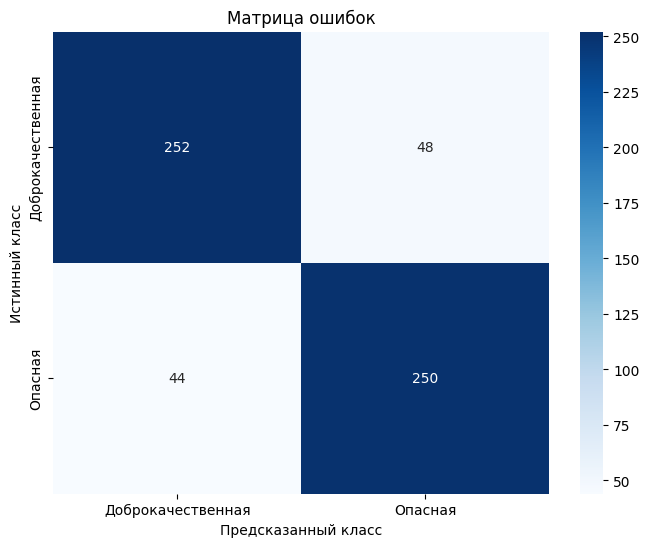


Отчет о классификации:
                   precision    recall  f1-score   support

Доброкачественная       0.85      0.84      0.85       300
          Опасная       0.84      0.85      0.84       294

         accuracy                           0.85       594
        macro avg       0.85      0.85      0.85       594
     weighted avg       0.85      0.85      0.85       594



In [12]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Доброкачественная', 'Опасная'],
            yticklabels=['Доброкачественная', 'Опасная'])
plt.title('Матрица ошибок')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.show()

print("\nОтчет о классификации:")
print(classification_report(all_labels, all_preds,
                          target_names=['Доброкачественная', 'Опасная']))

# Демонстрация работы


Результат анализа изображения:
Класс: Доброкачественная
Уверенность: 87.29%
Вероятность 'Доброкачественная': 87.29%
Вероятность 'Опасная': 12.71%


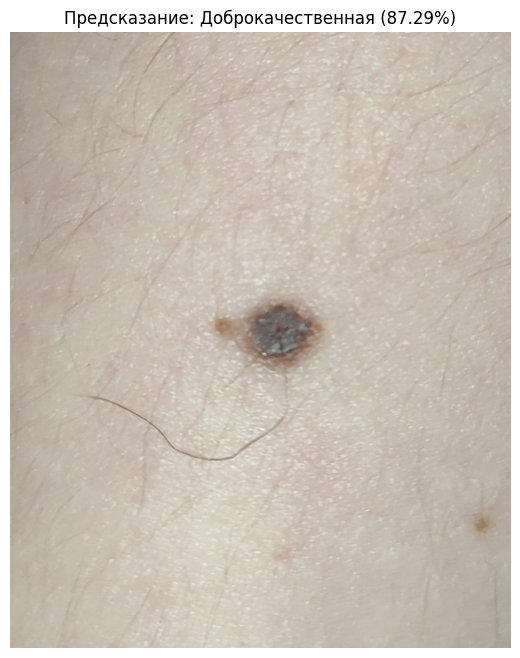

In [13]:
def predict_image(image_path):
    try:
        image = Image.open(image_path).convert('RGB')
        image_tensor = val_transform(image).unsqueeze((0)).to(device)

        model.eval()
        with torch.no_grad():
            outputs = model(image_tensor).logits
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

        class_names = ['Доброкачественная', 'Опасная']
        result = {
            'class': class_names[predicted.item()],
            'confidence': probabilities[0][predicted.item()].item(),
            'probabilities': {
                'Доброкачественная': probabilities[0][0].item(),
                'Опасная': probabilities[0][1].item()
            }
        }

        return result
    except Exception as e:
        print(f"Ошибка при обработке изображения: {e}")
        return None

image_path = "/content/родинка.jpg"

if os.path.exists(image_path):
    result = predict_image(image_path)
    if result:
        print(f"\nРезультат анализа изображения:")
        print(f"Класс: {result['class']}")
        print(f"Уверенность: {result['confidence']:.2%}")
        print(f"Вероятность 'Доброкачественная': {result['probabilities']['Доброкачественная']:.2%}")
        print(f"Вероятность 'Опасная': {result['probabilities']['Опасная']:.2%}")

        image = Image.open(image_path).convert('RGB')
        plt.figure(figsize=(8, 8))
        plt.imshow(image)
        plt.title(f"Предсказание: {result['class']} ({result['confidence']:.2%})")
        plt.axis('off')
        plt.show()
else:
    print(f"Файл {image_path} не найден!")
    print("\nКак загрузить изображение в Colab:")
    print("1. На левой панели нажмите на иконку 'файлы' (папка)")
    print("2. Нажмите 'Загрузить' и выберите файл с изображением")
    print("3. Убедитесь, что файл загружен в корневую папку /content/")
    print("4. Проверьте имя файла (учитывайте регистр и расширение)")

# Визуализация результатов

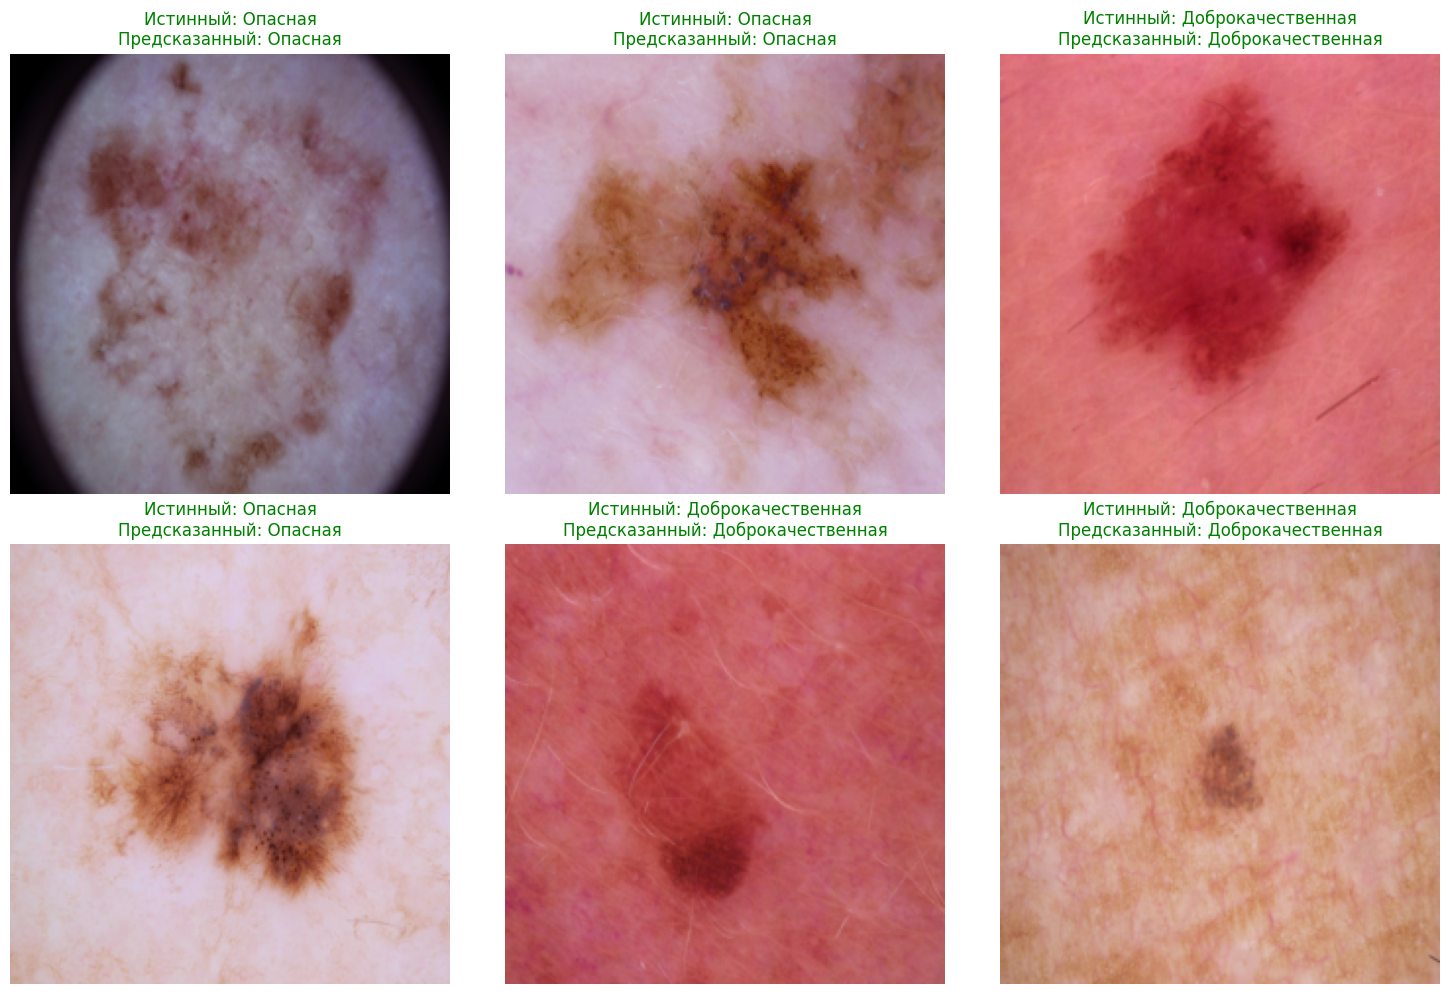

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
model.eval()

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        if i >= 2:
            break
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, predictions = torch.max(outputs, 1)

        for j in range(min(3, len(images))):
            ax = axes[i, j]
            img = images[j].cpu().permute(1, 2, 0).numpy()
            img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img = np.clip(img, 0, 1)

            true_label = 'Доброкачественная' if labels[j] == 0 else 'Опасная'
            pred_label = 'Доброкачественная' if predictions[j] == 0 else 'Опасная'
            color = 'green' if true_label == pred_label else 'red'

            ax.imshow(img)
            ax.set_title(f'Истинный: {true_label}\nПредсказанный: {pred_label}', color=color)
            ax.axis('off')

plt.tight_layout()
plt.show()

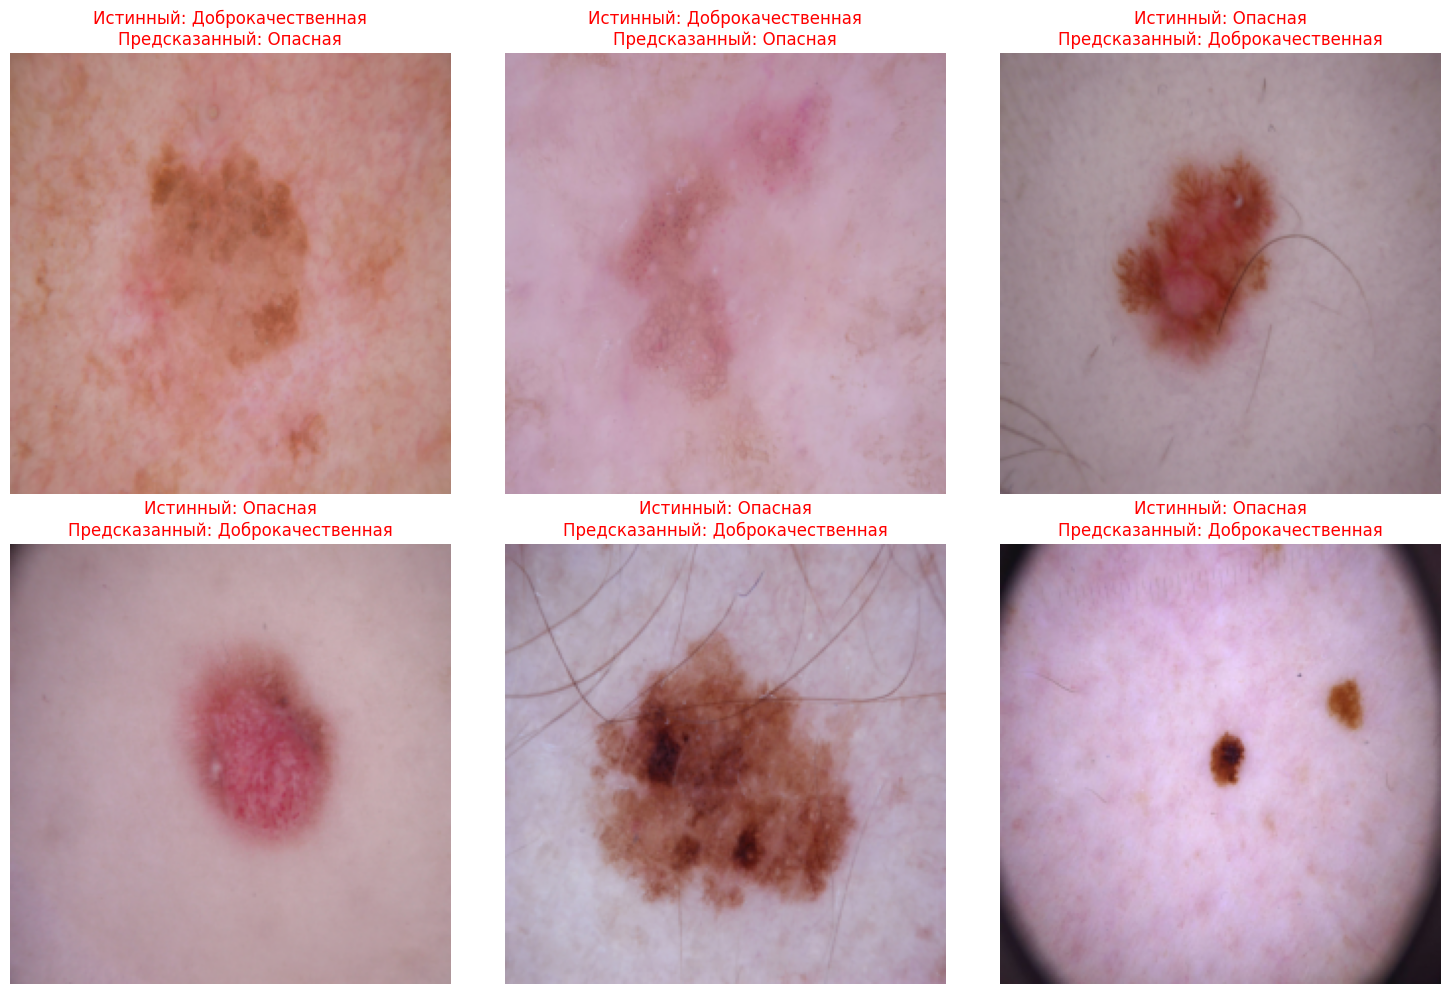

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
model.eval()

errors_shown = 0
max_errors = 6

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, predictions = torch.max(outputs, 1)

        for j in range(len(images)):
            true_label = 'Доброкачественная' if labels[j] == 0 else 'Опасная'
            pred_label = 'Доброкачественная' if predictions[j] == 0 else 'Опасная'

            if true_label != pred_label:
                ax = axes[errors_shown // 3, errors_shown % 3]
                img = images[j].cpu().permute(1, 2, 0).numpy()
                img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                img = np.clip(img, 0, 1)

                ax.imshow(img)
                ax.set_title(f'Истинный: {true_label}\nПредсказанный: {pred_label}', color='red')
                ax.axis('off')

                errors_shown += 1
                if errors_shown >= max_errors:
                    break
        if errors_shown >= max_errors:
            break

plt.tight_layout()
plt.show()


In [15]:
# сохранение
torch.save(model.state_dict(), 'skin_lesion_model.pth')